<a href="https://colab.research.google.com/github/a-coding-Kat/dlbs-mini-challenge-hs26/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Why YOLOv8?
It strikes a good balance of:

- High accuracy for complex features (won't confuse Santa with similar-looking humans)
- Fast inference for real-time detection
- Easy fine-tuning on custom Santa datasets
- Strong feature extraction to distinguish Santa's unique characteristics (hat + beard + red suit combo, belly shape, gift bag, etc.)

Guidelines for the project

 - data inspection: how many samples, classes, labels, class imbalances
 - formulate clear research question
 - skeleton model, overtrain
 - different models, one class, several classes
 - dicuss dataset challenges and how to overcome them

- images 500x500
- object classes, distributions, statistics, imbalanes, bias .. consider when training, weighted loss
- variaility of students, researchers say about it
- qualitative and quantitative sense of data

 - while training your model, you can choose a minimum IoU score needed for a predicted box to be regarded as an accurate positive detection, which allows using IoU to set a threshold for object detection

 - visualize image labels

## Mount the Drive Storage

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/FHNW/HS_25/DLBS/minichallenge_hs25_object_detection

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/FHNW/HS_25/DLBS/minichallenge_hs25_object_detection


## Load the Roboflow dataset

In [2]:
!pip install roboflow -q

# Roboflow initialization and download dataset
from google.colab import userdata
ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')

from roboflow import Roboflow
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("dlbs-xi5zk").project("santa-qqpxm")
dataset = project.version(4).download("yolov8")

# Print dataset info
print(f"\n✅ Dataset downloaded to: {dataset.location}")
print(f"Dataset name: {dataset.name}")

loading Roboflow workspace...
loading Roboflow project...

✅ Dataset downloaded to: /content/drive/My Drive/FHNW/HS_25/DLBS/minichallenge_hs25_object_detection/Santa-4
Dataset name: Santa


In [3]:
import os

DATASET_PATH = 'Santa-4'
# ORIGINAL_IMAGE_DIR = os.path.join(DATASET_PATH, 'train', 'images')
# confirm the images and labels folders exist
!ls -F {DATASET_PATH}/train/

images/  labels/  labels.cache


In [5]:
# Check images
!ls -F Santa-4/train/images | head -n 5

00up-santa-1-48c8-mediumSquareAt3X_jpg.rf.5f6d8fb1914682b589a309381a52d49f.jpg
0-38862400_1671944344_santa_jpg.rf.01851ac3517e39f04471746e409a5ead.jpg
101_Santa_jpg.rf.faf078360adefe987897f59f4a49e718.jpg
106_Santa_jpg.rf.b9437d6b9a32d3fc0caeccff05c304bf.jpg
108_Santa_jpg.rf.c59e2e56e62f24cad056ae0dca8b0e67.jpg


In [6]:
# Check their annotations
!ls -F Santa-4/train/labels/ | head -n 5

00up-santa-1-48c8-mediumSquareAt3X_jpg.rf.5f6d8fb1914682b589a309381a52d49f.txt
0-38862400_1671944344_santa_jpg.rf.01851ac3517e39f04471746e409a5ead.txt
101_Santa_jpg.rf.faf078360adefe987897f59f4a49e718.txt
106_Santa_jpg.rf.b9437d6b9a32d3fc0caeccff05c304bf.txt
108_Santa_jpg.rf.c59e2e56e62f24cad056ae0dca8b0e67.txt


In [ ]:
# Prepare small dataset for overfitting


## Overfitting the YOLOv8 Model

**Why overfit?**

- Sanity check — Confirms model can learn your data
- Debug annotations — If it still fails, labels might be wrong
- Baseline — Compare against non-overfit model
- Verify setup — GPU, data loading, YOLO installation all working

**How to overfit a model?**   

- Train for many epochs
- Larger batches that result in sharp minima and fit training data perfectly, but generalize poorly
- No dropout, early stopping or regularization
- No data augmentation

### a) Monitoring Model Training
YOLOv8's model.train() method automatically calculates and logs a metrics essential for object detection.   
By initializing W&B, these metrics are sent directly to the W&B dashboard for real-time monitoring and comparison.

W&B automatically generates interactive charts showing Box Loss, Cls Loss, mAP@0.5, and mAP@[0.5:0.95] over epochs.

**1. Core Loss Metrics (Error Monitoring)**

These metrics monitor the model's primary objective—minimizing errors. They are calculated for both the training and validation splits at every step/epoch.

- _Box Loss (box_loss)_: Measures how accurately the model predicts the location and size of the bounding boxes. A lower value means better localization.

- _Classification Loss (cls_loss)_: Measures how accurately the model predicts the class label (Santa) inside the box. A lower value means better classification.

- _D-Loss (dfl_loss)_: Distribution Focal Loss. This is related to how YOLOv8 (specifically its anchor-free head) models the bounding box as a probability distribution. A lower value indicates more precise box boundary prediction.

**2. Standard Object Detection Metrics**

These metrics quantify the model's performance on the validation set after each epoch. They are generally considered the most important indicators of model quality.

- _Precision (P)_: The proportion of positive predictions that were actually correct. High precision means fewer false alarms.

- _Recall (R)_: The proportion of actual positive instances that were correctly identified. High recall means fewer missed objects.

- _mean Average Precision (mAP)_: The single most important metric. It measures the quality of both detection (Precision and Recall) and localization across all classes and various confidence thresholds.

    mAP@0.5: The mAP calculated at an Intersection over Union (IoU) threshold of 0.5 (a "loose" correct detection).

    mAP@[0.5:0.95]: The average mAP calculated across IoU thresholds from 0.5 to 0.95 in 0.05 increments (a "strict" overall quality measure).

In [7]:
!nvidia-smi

Wed Dec 10 23:45:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   32C    P0             55W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [8]:
# Install YOLO library
!pip install ultralytics -q

from IPython import display
display.clear_output()

# prevent ultralytics from tracking activity
!yolo settings sync=False

import ultralytics
ultralytics.checks()

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Setup complete ✅ (12 CPUs, 167.1 GB RAM, 38.6/235.7 GB disk)


In [9]:
os.getcwd()

'/content/drive/MyDrive/FHNW/HS_25/DLBS/minichallenge_hs25_object_detection'

In [10]:
# W&B login
!pip install wandb -q
import wandb
WANDB_API_KEY = userdata.get('WANDB_API_KEY')
wandb.login(key=WANDB_API_KEY)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: katai (brain-health) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## YOLO Training

Model summary (fused):
- 72 layers,
- 3,005,843 parameters,
- 0 gradients,
- 8.1 GFLOPs

Selected training parameters:

Key Parameters:

- data: Points to the dataset YAML file, which contains paths to images and labels, along with the number of classes and class names.

- epochs: The number of times the entire dataset will be used in training.

- batch_size: Defines how many images will be processed at once during training.

- imgsz: Image size to resize each input image to during training (common choices: 320, 416, 640).

- lr0 and lr1: Learning rates for the initial and final stages of training (useful for setting up learning rate schedules).

- momentum: Momentum of the optimizer (helps accelerate the training process).

- optimizer: You can choose between Adam and SGD for the optimizer, with Adam being commonly used for object detection models.

- project: The project name in WandB where the run data will be logged.

- tags: Tags are used to categorize runs in WandB.

- verbose: Set to True for detailed logs during training.

- save: Ensures training logs and results are saved during the run.

- exist_ok: If set to True, it will overwrite an existing run with the same name.

- img_weights: If using weighted images (optional).


By setting freeze: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], we ensure that the weights in the backbone remain fixed, and only the weights in the head (the detection layers) are updated.

In [13]:
import shutil
from ultralytics import YOLO

# --- LOAD MODEL FROM CACHE ---
MODEL_NAME = 'yolov8n.pt'
DRIVE_PATH = '/content/drive/My Drive/FHNW/HS_25/DLBS/minichallenge_hs25_object_detection/models_cache/'
MODEL_PATH = os.path.join(DRIVE_PATH, MODEL_NAME)

os.makedirs(DRIVE_PATH, exist_ok=True)

if os.path.exists(MODEL_PATH):
    print(f"✅ Loading from cache: {MODEL_PATH}")
    model = YOLO(MODEL_PATH)
else:
    print(f"⬇️ Downloading {MODEL_NAME}...")
    model = YOLO(MODEL_NAME)
    source = MODEL_NAME if os.path.exists(MODEL_NAME) else os.path.expanduser(f'~/.config/ultralytics/{MODEL_NAME}')
    if os.path.exists(source):
        shutil.copyfile(source, MODEL_PATH)
        if source == MODEL_NAME:
            os.remove(MODEL_NAME)
        print(f"✅ Saved to Drive: {MODEL_PATH}")

# Set up data info location
dataset_yaml = f'{DATASET_PATH}/data.yaml'

# Training parameters for each run, different freezing, batch size, dataset size
# run 1 config
overfitting_config_1 = {
    'data': dataset_yaml,
    'epochs': 300,            # Large number of epochs, training too long
    'imgsz': 640,             # YOLO automatically resizes images to 640x640
    'batch': 75,              # Larger batches lead to overfitting
    'patience': 0,            # No early stopping
    'device': 0,
    'augment': False,         # No augmentation
    'lr0': 0.005,              # Higher learning rate
    'momentum': 0.9,
    'weight_decay': 0.0,      # No L2 regularization
    'dropout': 0.0,           # No dropout
    'verbose': True,
    'save': True,
    'project': 'runs/detect', # Ultralytics project folder
    'name': 'overfit_run_1', # Ultralytics run folder name
    'val': True, # Ensure validation is used
    'exist_ok': True
}

overfitting_config_2 = {
    'data': dataset_yaml,
    'epochs': 300,            # Large number of epochs, training too long
    'imgsz': 640,             # YOLO automatically resizes images to 640x640
    'batch': 80,              # Larger batches lead to overfitting
    'patience': 0,            # No early stopping
    'device': 0,
    'augment': False,         # No augmentation
    'close_mosaic': 0,        # Disable Mosaic augmentation at the beginning immediately
    'freeze': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],  # freeze the first 10 layers
    'lr0': 0.01,              # Higher learning rate
    'momentum': 0.9,
    'weight_decay': 0.0,      # No L2 regularization
    'dropout': 0.0,           # No dropout
    'verbose': True,
    'save': True,
    'project': 'runs/detect', # Ultralytics project folder
    'name': 'overfit_run_2', # Ultralytics run folder name
    'val': True, # Ensure validation is used
    'exist_ok': True
}

✅ Loading from cache: /content/drive/My Drive/FHNW/HS_25/DLBS/minichallenge_hs25_object_detection/models_cache/yolov8n.pt


🚀 Starting training (designed to overfit) ...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=80, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Santa-4/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/My Drive/FHNW/HS_25/DLBS/minichallenge_hs25_object_detection/models_cache/yolov8n.pt, momentum=0.9, mosaic=1.0, multi

✅ Training complete!


In [ ]:
# --- RUN 1
# --- W&B INITIALIZATION ---
wandb.init(
    project='yolov8_santa_train',
    entity='katai',
    config=overfitting_config_1,
    name='overfit_run_2'
)

# --- TRAIN ---
print("🚀 Starting training (designed to overfit) ...")
results = model.train(**overfitting_config_1)

# --- CLEANUP ---
wandb.finish()
print("✅ Training complete!")

In [ ]:
# --- RUN 2: frozen backbone
# --- W&B INITIALIZATION ---
wandb.init(
    project='yolov8_santa_train',
    entity='katai',
    config=overfitting_config_2,
    name='overfit_run_2'
)

# --- TRAIN ---
print("🚀 Starting training (designed to overfit) ...")
results = model.train(**overfitting_config_2)

# --- CLEANUP ---
wandb.finish()
print("✅ Training complete!")

In [ ]:
# --- RUN 3: small dataset
# --- W&B INITIALIZATION ---
wandb.init(
    project='yolov8_santa_train',
    entity='katai',
    config=overfitting_config_3,
    name='overfit_run_3'
)

# --- TRAIN ---
print("🚀 Starting training (designed to overfit) ...")
results = model.train(**overfitting_config_3)

# --- CLEANUP ---
wandb.finish()
print("✅ Training complete!")

In [1]:
# --- CONFIGURATION ---
DRIVE_MODEL_DIR = '/content/drive/My Drive/FHNW/HS_25/DLBS/minichallenge_hs25_object_detection/yolov8_results/'
RUNS_DIR = 'runs/detect/overfit_run_2' # Ultralytics default save path
BEST_WEIGHTS_FILENAME = 'best_overfit.pt'
OUTPUT_WEIGHTS_NAME = 'weights_overfit.pt'

# Ensure the Google Drive target directory exists
os.makedirs(DRIVE_MODEL_DIR, exist_ok=True)
# ---------------------

NameError: name 'os' is not defined

In [ ]:
# 4. Save Best Model to Google Drive
# Construct the full path where Ultralytics saves the best weights
ultralytics_save_path = os.path.join(RUNS_DIR, 'weights', BEST_WEIGHTS_FILENAME)

# Construct the final destination path in Google Drive
drive_destination_path = os.path.join(DRIVE_MODEL_DIR, OUTPUT_WEIGHTS_NAME)

# Use the !cp command to copy the weights from the local Colab disk to Google Drive
# We use the !cp command (shell command) which is often more reliable than Python's shutil in Colab
print(f"\nAttempting to copy best weights from {ultralytics_save_path} to Google Drive...")
!cp {ultralytics_save_path} "{drive_destination_path}"

print(f"✅ Best trained weights saved to Google Drive as: {drive_destination_path}")

Checking for plots in: runs/detect/overfit_run_2

--- Displaying results.png ---


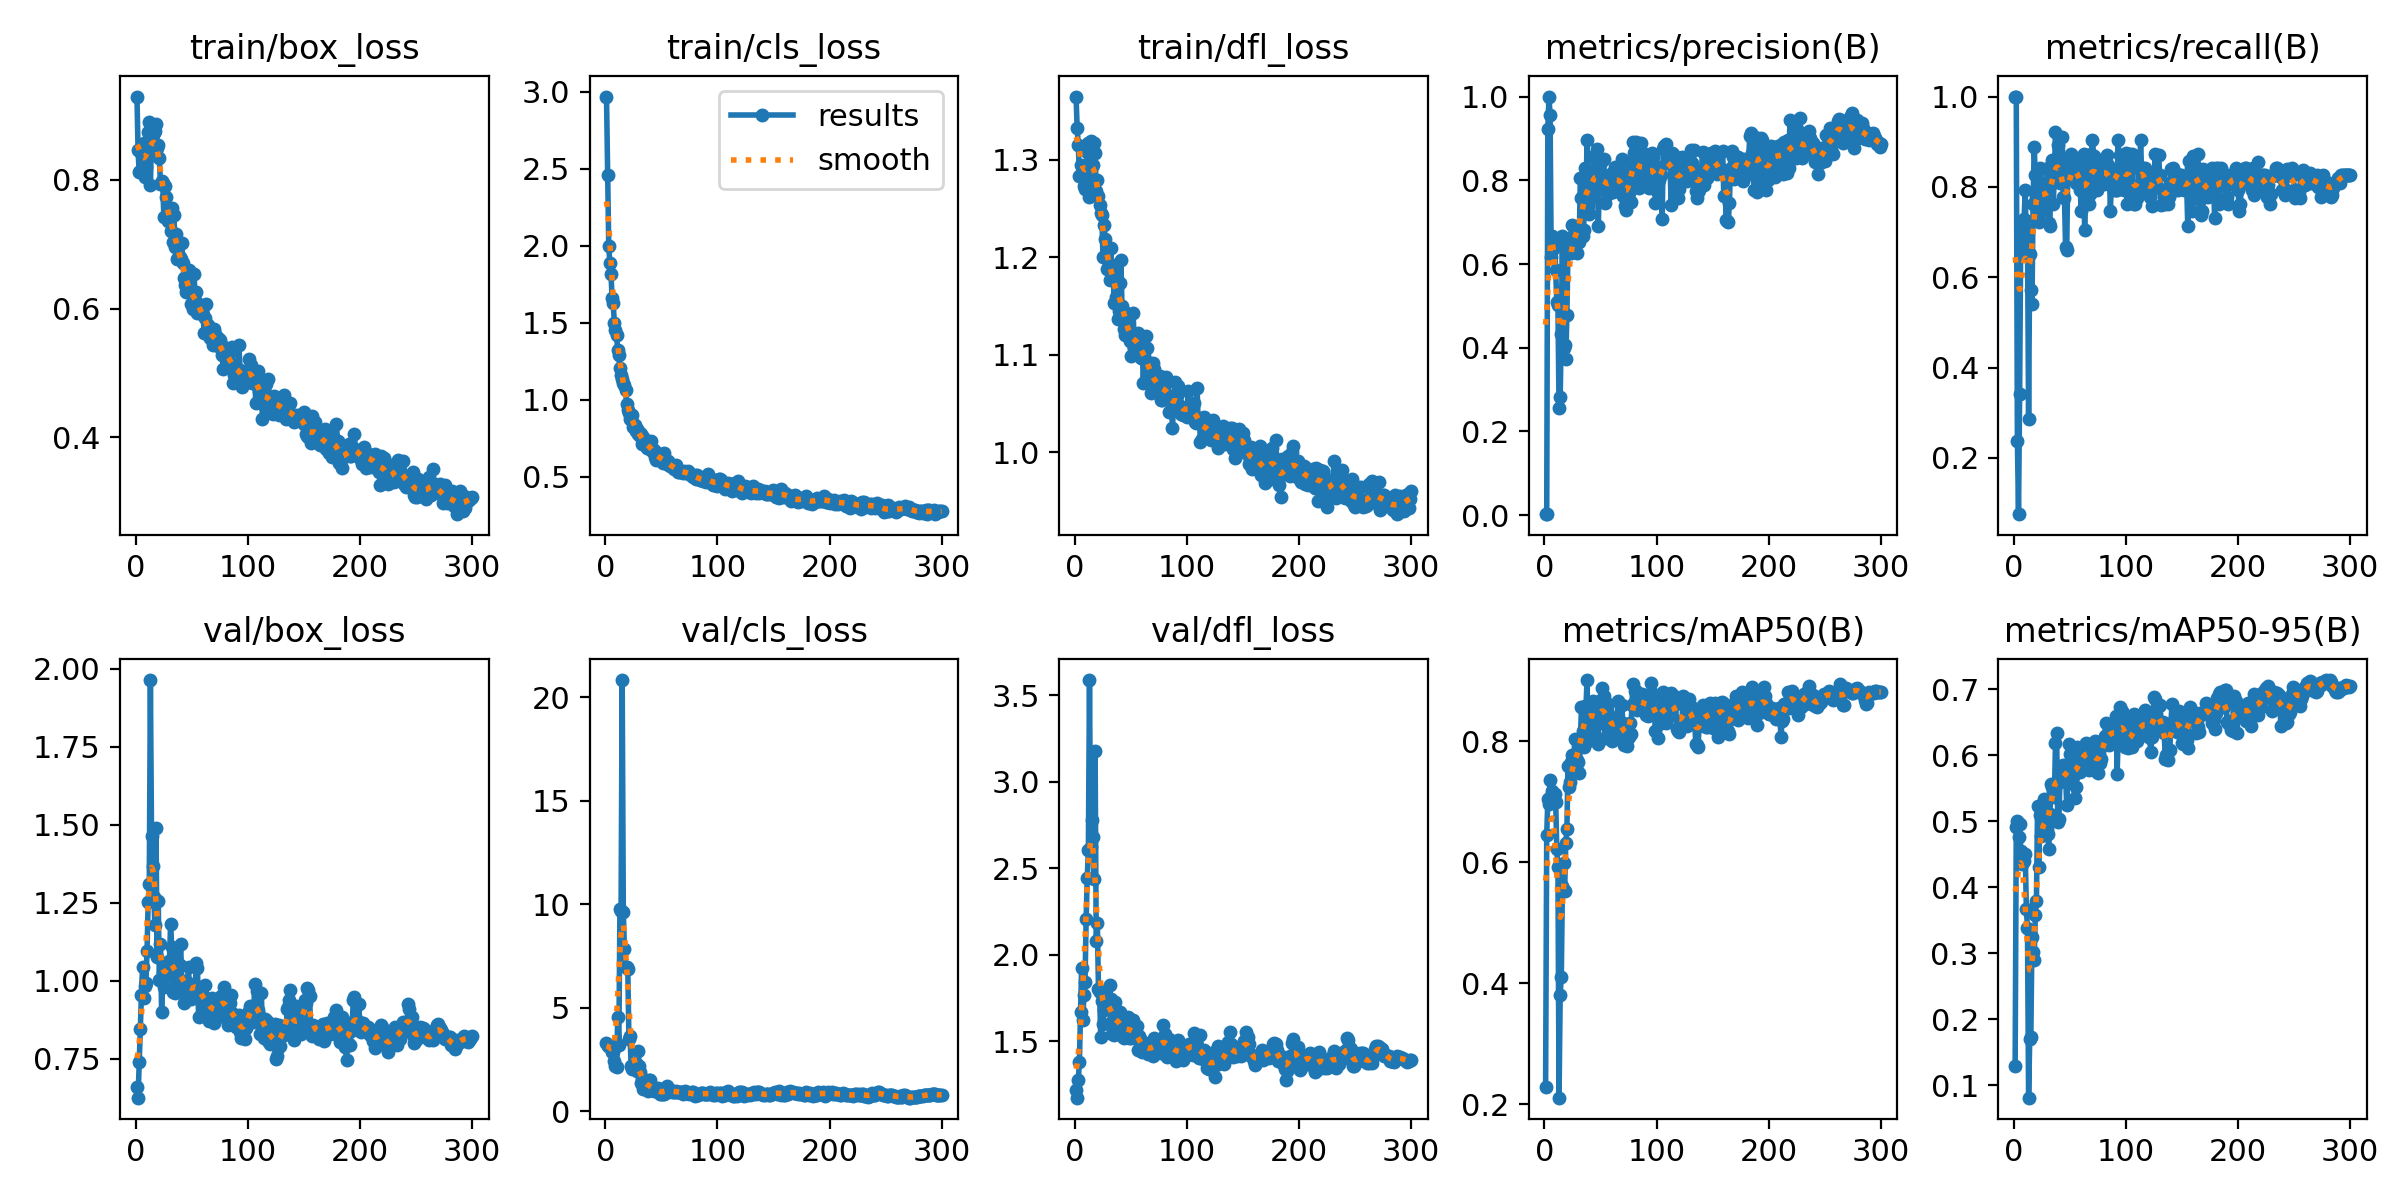

⚠️ Warning: Could not find F1_curve.png in runs/detect/overfit_run_2. Perhaps the training run hasn't finished yet or there was an error.

--- Displaying confusion_matrix.png ---


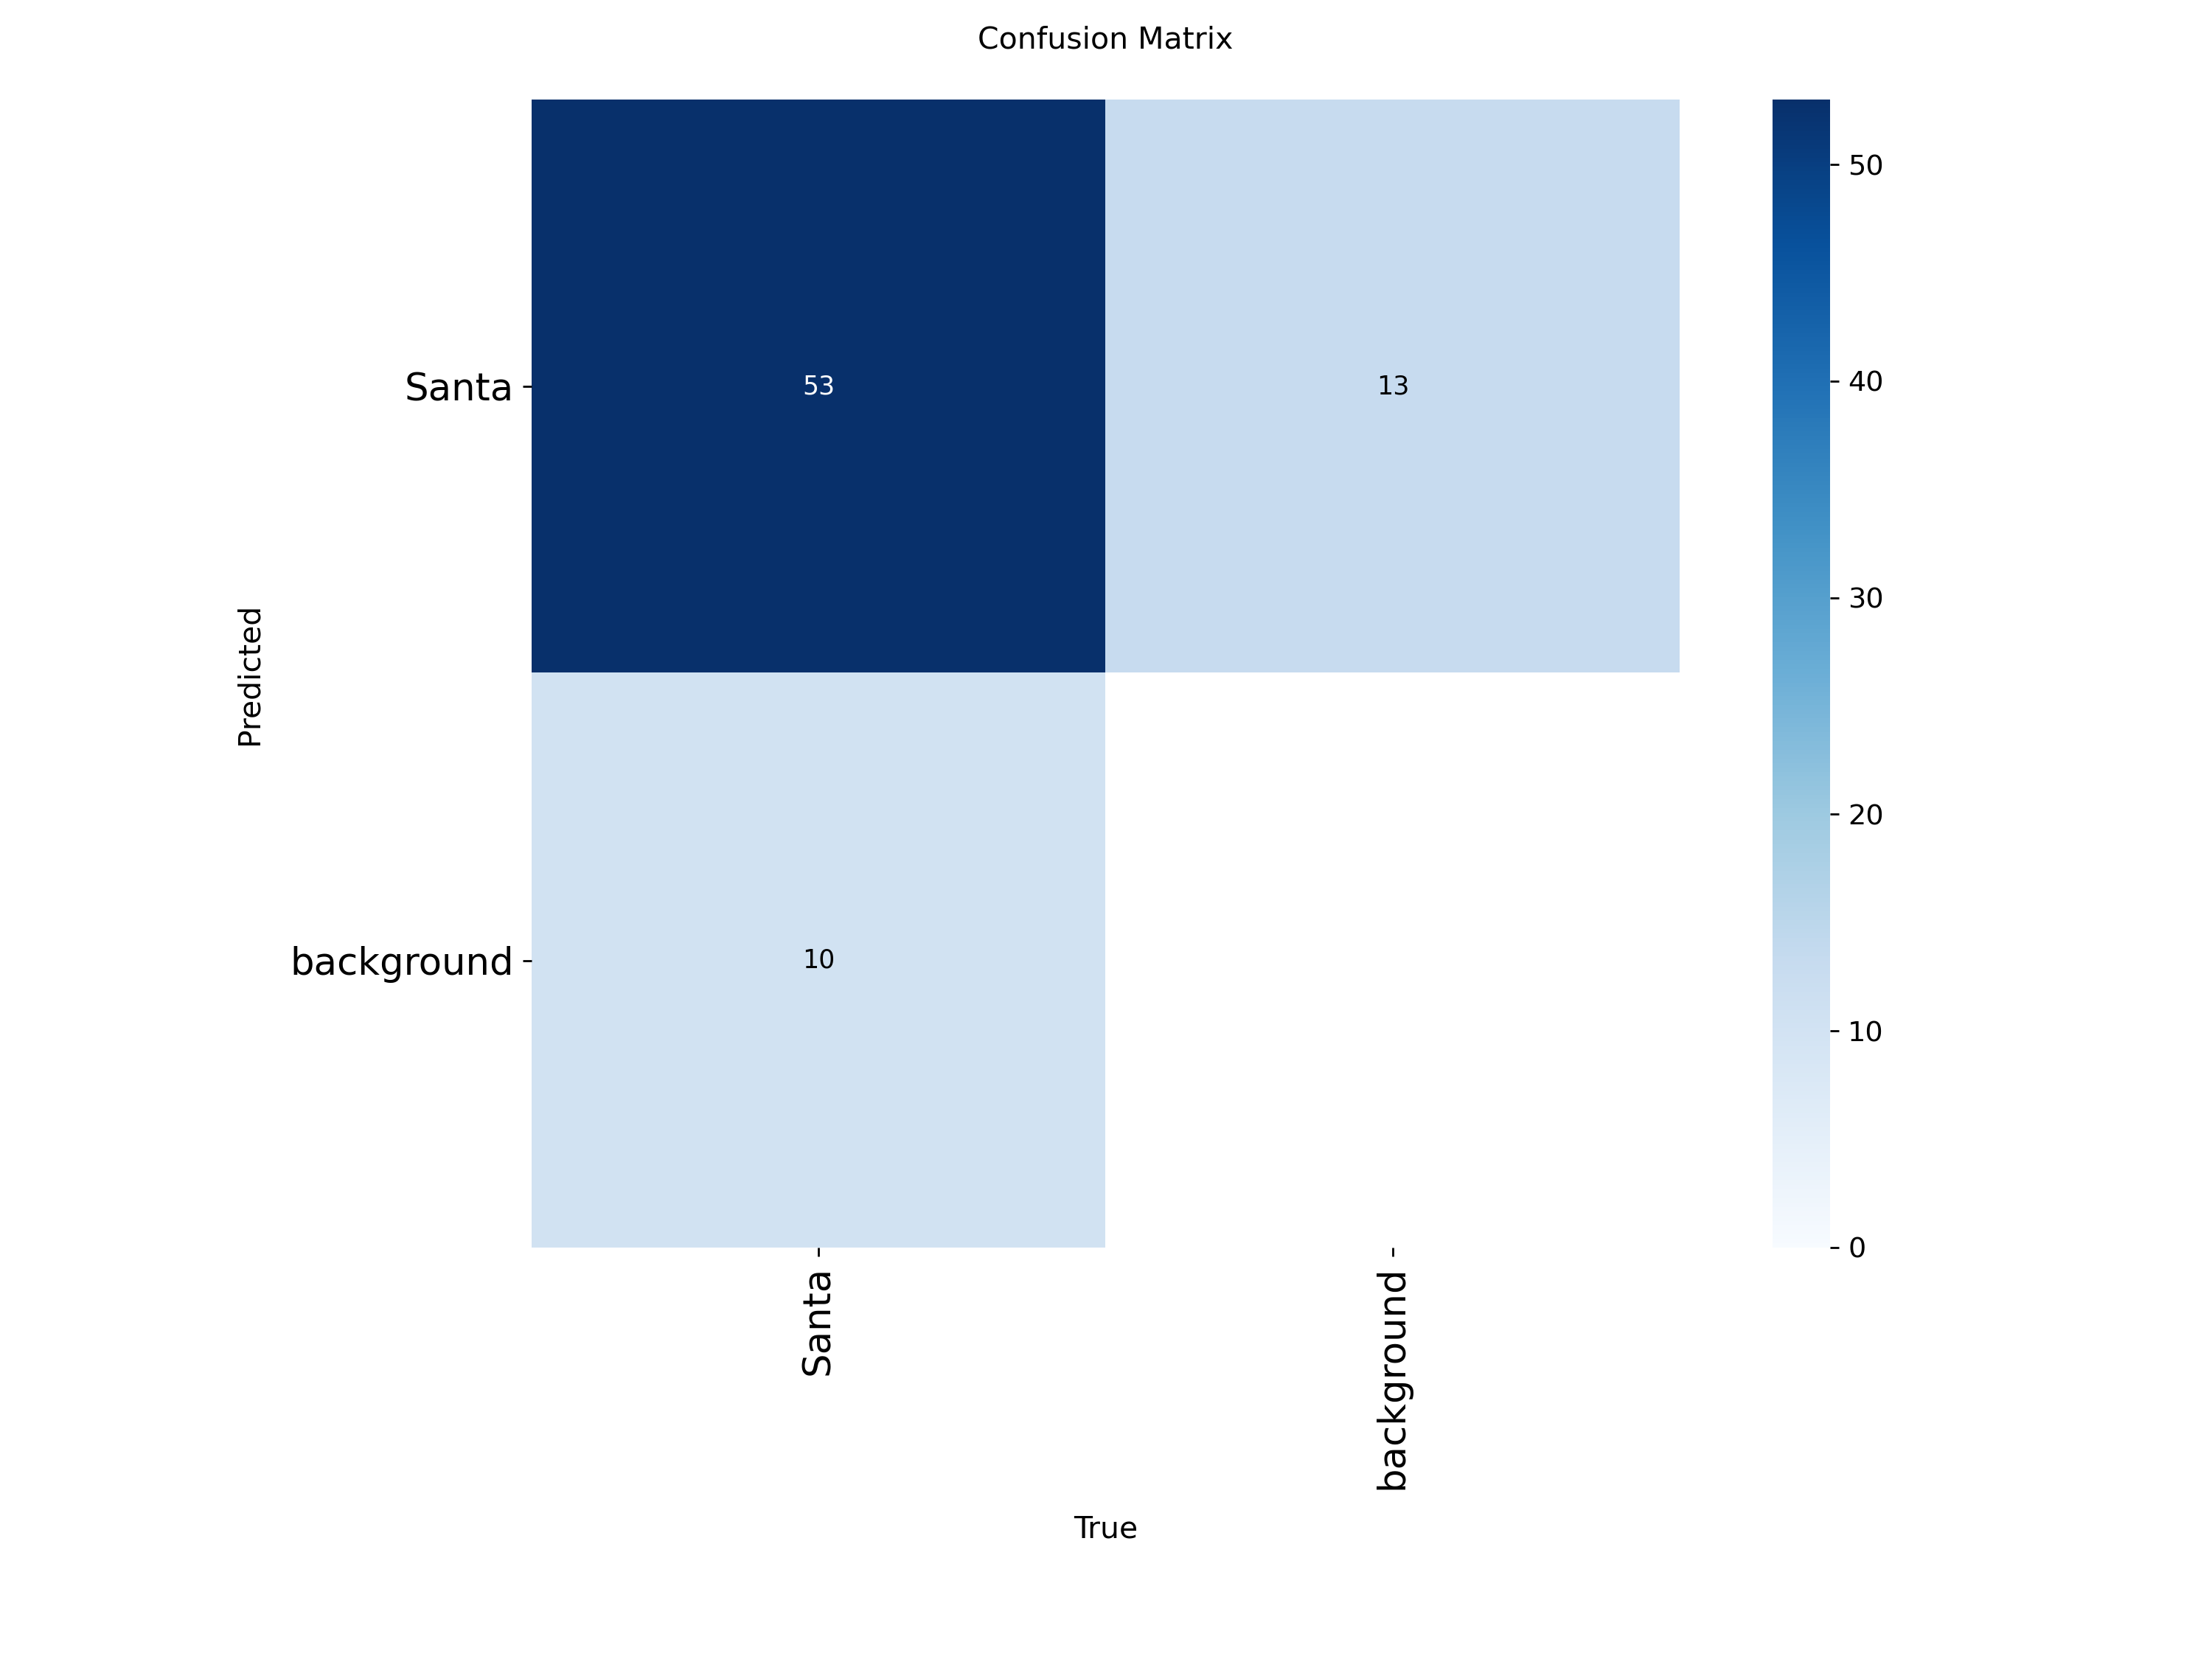

In [16]:
import glob
from IPython.display import Image, display

# 1. Define the run folder path
# This should match the 'project' and 'name' parameters in your overfitting_config
RUN_FOLDER = "runs/detect/overfit_run_2"

# 2. Define which plot files you want to see
plot_files = [
    'results.png',           # Main plot showing loss, mAP, P, R over epochs
    'F1_curve.png',          # F1 score curve
    'confusion_matrix.png'   # Final confusion matrix
]

print(f"Checking for plots in: {RUN_FOLDER}")

# 3. Iterate and display each plot found
for filename in plot_files:
    try:
        # Use glob to find the exact file path
        file_path = glob.glob(f'{RUN_FOLDER}/{filename}')[0]

        print(f"\n--- Displaying {filename} ---")
        display(Image(filename=file_path))
    except IndexError:
        print(f"⚠️ Warning: Could not find {filename} in {RUN_FOLDER}. Perhaps the training run hasn't finished yet or there was an error.")
    except Exception as e:
        print(f"Error displaying {filename}: {e}")

In [ ]:
# %cd {HOME}
# !yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=25 imgsz=800 plots=True

In [ ]:
run = wandb.Api().run("katai/yolov8_santa_train/runs/pch7rofo")
# plot a specific metric, like training loss or validation loss
wandb.log({'train_loss': box_loss, 'val_loss': box_loss})